In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2024-11-12 14:46 (eradiate v0.29.1)*

In [2]:
%load_ext eradiate

In [3]:
import eradiate
eradiate.set_mode("mono_single")
from eradiate import unit_registry as ureg
from eradiate import scenes as ertsc
import mitsuba as mi
import drjit as dr
assert (eradiate.__version__, mi.__version__, dr.__version__) == ('0.29.1', '3.5.2', '0.4.6')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

The following helper function allows to display an image from a perspective camera measure output dataset.

In [4]:
def show_camera(
    exp,
    measure_id,
    robust=True,
    add_colorbar=False,
    vmin=None,
    vmax=None,
):
    
    _, ax = plt.subplots(1, 1)
    exp.results[measure_id]["radiance"].squeeze(drop=True).plot.imshow(
        ax=ax,
        origin="upper",
        vmin=vmin,
        vmax=vmax,
        robust=robust,
        add_colorbar=add_colorbar,
    )
    ax.set_aspect(1)  # Ensures that pixels are represented as squares
    plt.show()
    plt.close()

In [5]:
particles_layer = ertsc.atmosphere.ParticleLayer(
    distribution=dict(type="exponential"),
)
atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere=ertsc.atmosphere.MolecularAtmosphere(),
    particle_layers=[particles_layer]
)

## Spectral properties modification

The RAMI-V test cases use constant reflectance properties for 14 different spectral bands. While this setup is suitable for defining a consistent benchmark framework, easy to implement and evaluate over multiple models, it may lack the necessary accuracy to represent a specific realistic problem. In particular, the Eradiate scene loader interpolates the spectral properties of the RAMI-V benchmark and thus deviates from the original specification. Users may also need to feed their own reflectance values depending on their own use case. The following section focuses on the modifcation of the `savannah_pre_fire` [1] test case using one-off, more realistic datasets of reflectance for the scene objects.

<Axes: xlabel='w'>

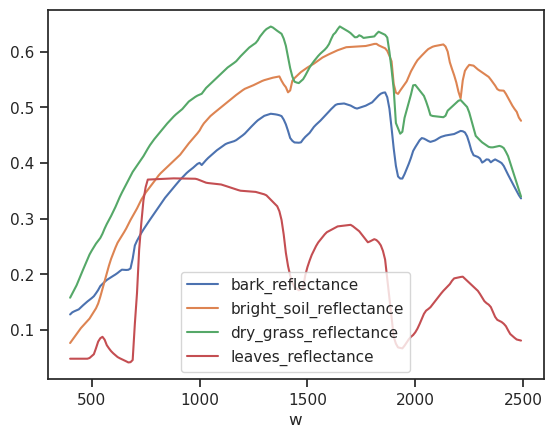

In [7]:
reflectance_dataset = xr.load_dataset("./data/savannah_pre_fire_reflectance_spectra.nc")
reflectance_dataset.to_dataframe().plot()

The `load_rami_scenario` function allows to pass an extra dictionary of replacement values for most of the scene's parameters before they are loaded into Eradiate. This dictionary is built using the ids of the different `InstancedElement` composing the scene, and recursively updates the sub-components that are identified by id. For instance, to modify a *grass* element, the following dictionary will allow to update the reflectance of the scene element with id `measured_stem` contained in the `InstanceElement` of id `grass1`: 

In [9]:
ex = {
    "grass1": {
        "measured_stem": {
            "reflectance": {
                "wavelengths": reflectance_dataset.dry_grass_reflectance.w,
                "values": reflectance_dataset.dry_grass_reflectance.values,
                "type": "interpolated"
            },
        },
    }
}

Since this type of modification requires knowledge of the 3D scene hierarchical structure in order to implement the dictionary, the following example is provided.

In [10]:
bark_spectrum =  {
    "wavelengths": reflectance_dataset.bark_reflectance.w,
    "values": reflectance_dataset.bark_reflectance.values,
    "type": "interpolated"
}

sav_pre_spectral_data = {
    "ground": {
        "reflectance": {
            "wavelengths": reflectance_dataset.bright_soil_reflectance.w,
            "values": reflectance_dataset.bright_soil_reflectance.values,
            "type": "interpolated"
        }
    }
} | {
    f"grass{idx}": {
        "measured_stem": {
            "reflectance": {
                "wavelengths": reflectance_dataset.dry_grass_reflectance.w,
                "values": reflectance_dataset.dry_grass_reflectance.values,
                "type": "interpolated"
            }
        },
    }
    for idx in range(0, 10)
} | {
    f"combretum_leafoff{idx}": {
        "measured_trunk": {
            "reflectance": bark_spectrum
        },
        "measured_branch": {
            "reflectance": bark_spectrum
        },
        "Bough": {
            "reflectance": bark_spectrum
        },
    }
    for idx in range(1, 6)
} | {
    f"combretum_leafoff{idx}_flat": {
        "measured_trunk": {
            "reflectance": bark_spectrum,
        },
        "measured_branch": {
            "reflectance": bark_spectrum,
        },
        "Bough": {
            "reflectance": bark_spectrum,
        },
    }
    for idx in range(1, 6)
} | {
    f"combretum_leafon{idx}": {
        "Leaf1": {
            "reflectance": {
                "wavelengths": reflectance_dataset.leaves_reflectance.w,
                "values": reflectance_dataset.leaves_reflectance.values,
                "type": "interpolated",
            }
        },
        "measured_trunk": {
            "reflectance": bark_spectrum,
        },
        "measured_branch": {
            "reflectance": bark_spectrum,
        },
        "Bough": {
            "reflectance": bark_spectrum,
        },
    }
    for idx in range(1, 3)
} | {
    f"combretum_leafon{idx}_flat": {
        "Leaf1": {
            "reflectance": {
                "wavelengths": reflectance_dataset.leaves_reflectance.w,
                "values": reflectance_dataset.leaves_reflectance.values,
                "type": "interpolated",
            }
        },
        "measured_trunk": {
            "reflectance": bark_spectrum,
        },
        "measured_branch": {
            "reflectance": bark_spectrum,
        },
        "Bough": {
            "reflectance": bark_spectrum,
        },
    }
    for idx in range(1, 3)
} | {
    f"merula{idx}": {
        "Leaf1": {
            "reflectance": {
                "wavelengths": reflectance_dataset.leaves_reflectance.w,
                "values": reflectance_dataset.leaves_reflectance.values,
                "type": "interpolated",
            }
        },
        "measured_trunk": {
            "reflectance": bark_spectrum,
        },
        "measured_branch": {
            "reflectance": bark_spectrum,
        },
        "Bough": {
            "reflectance": bark_spectrum,
        },
    }
    for idx in range(1, 5)
}

In [11]:
canopy_dict = ertsc.biosphere.load_rami_scenario("HET50_SAV_PRE")
canopy_dict_mod = ertsc.biosphere.load_rami_scenario("HET50_SAV_PRE", spectral_data=sav_pre_spectral_data)

In [16]:
rgb_measure_dict = {
    "type": "perspective",
    "film_resolution": (256, 256),
    "origin": [2.0, 2.0, 2.0],
    "target": [0.0, 0.0, 2.2],
    "up": [0.0, 0.0, 1.0],
    "sampler": "ldsampler",
    "fov": 50.0,
    "spp": 64,
    "srf": {
        "type": "multi_delta",
        "wavelengths": np.array([660.0, 550.0, 440.0]) * ureg.nm,
    },
}


exp = eradiate.experiments.CanopyAtmosphereExperiment(
    **canopy_dict,
    atmosphere=atmosphere,
    measures=rgb_measure_dict,
    illumination={"type": "directional", "zenith": 45.0, "azimuth": 350.0},
)

In [17]:
eradiate.run(exp)

0/3|          | 00:00, ETA=?

<xarray.Dataset>
Dimensions:     (sza: 1, saa: 1, w: 3, y_index: 256, x_index: 256)
Coordinates:
  * sza         (sza) float64 45.0
  * saa         (saa) float64 350.0
  * w           (w) float64 440.0 550.0 660.0
  * y_index     (y_index) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
    y           (y_index) float64 0.0 0.003922 0.007843 ... 0.9922 0.9961 1.0
  * x_index     (x_index) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
    x           (x_index) float64 0.0 0.003922 0.007843 ... 0.9922 0.9961 1.0
Data variables:
    radiance    (w, y_index, x_index, saa, sza) float64 0.09963 ... 0.05908
    irradiance  (sza, saa, w) float64 1.289 1.349 1.095

A RGB image can be created from the output dataset.

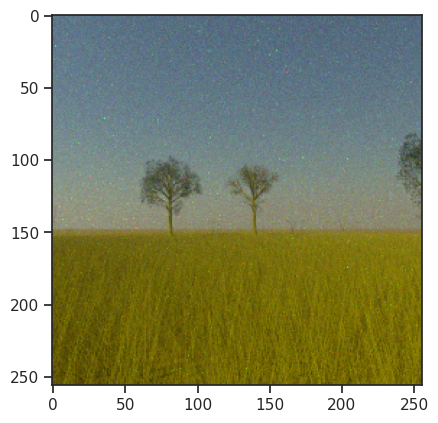

In [18]:
img_dat = eradiate.xarray.interp.dataarray_to_rgb(exp.results["measure"].radiance, channels=[("w", 660), ("w", 550), ("w", 440)]).squeeze()
plt.imshow(img_dat)

Let's simulate the modified scene:

In [21]:
exp_mod = eradiate.experiments.CanopyAtmosphereExperiment(
    **canopy_dict_mod,
    atmosphere=atmosphere,
    measures=rgb_measure_dict,
    illumination={"type": "directional", "zenith": 45.0, "azimuth": 350.0},
)

eradiate.run(exp_mod)
img_dat_mod = eradiate.xarray.interp.dataarray_to_rgb(exp_mod.results["measure"].radiance, channels=[("w", 660), ("w", 550), ("w", 440)]).squeeze()

0/3|          | 00:00, ETA=?

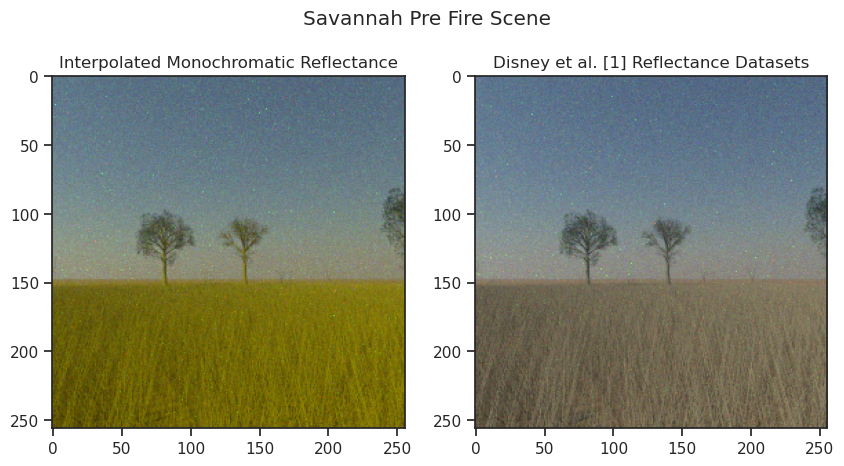

In [22]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img_dat)
ax2.imshow(img_dat_mod)

plt.suptitle("Savannah Pre Fire Scene")
ax1.set_title("Interpolated Monochromatic Reflectance")
ax2.set_title("Disney et al. [1] Reflectance Datasets")

plt.savefig("savannah_pre_fire_comparison.png")

[1] M.I. Disney, P. Lewis, J. Gomez-Dans, D. Roy, M.J. Wooster, D. Lajas, 3D radiative transfer modelling of fire impacts on a two-layer savanna system, Remote Sensing of Environment, Volume 115, Issue 8, 2011, Pages 1866-1881, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2011.03.010. (https://www.sciencedirect.com/science/article/pii/S0034425711000873)
